# Custom Datasets




In [163]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import requests
import zipfile
from pathlib import Path
import matplotlib.pyplot as plt

In [164]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
elif torch.backends.mps.is_available()
    device = torch.device('mps')
else:
    device = torch.device("cpu")



In [165]:
device = "cpu"
print(device)

cpu


In [166]:
# Get the data with subset of Food101 dataset
data_path = Path('~/Developer/Datasets/food-101').expanduser()
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
    print(f"{image_path} already exists, skipping downloading")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading...")
    f.write(request.content)
    
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", 'r') as zip_ref:
    print("Unzipping...")
    zip_ref.extractall(image_path)
    
print("Done!")

/Users/georgeli/Developer/Datasets/food-101/pizza_steak_sushi already exists, skipping downloading
Downloading...
Unzipping...
Done!


225 75
torch.Size([32, 3, 224, 224]) torch.Size([32])
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1176, 0.1216, 0.1176,  ..., 0.7608, 0.7490, 0.7569],
          [0.1098, 0.1176, 0.1216,  ..., 0.7608, 0.7569, 0.7490],
          [0.1020, 0.1098, 0.1098,  ..., 0.7569, 0.7529, 0.7412]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0510, 0.0549, 0.0510,  ..., 0.7882, 0.7765, 0.7843],
          [0.0431, 0.0510, 0.0471,  ..., 0.7882, 0.7843, 0.7765],
          [0.0353, 0.0392, 0.0392,  ..., 0.7843, 0.7804, 0.7686]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.000

Text(0.5, 1.0, 'pizza')

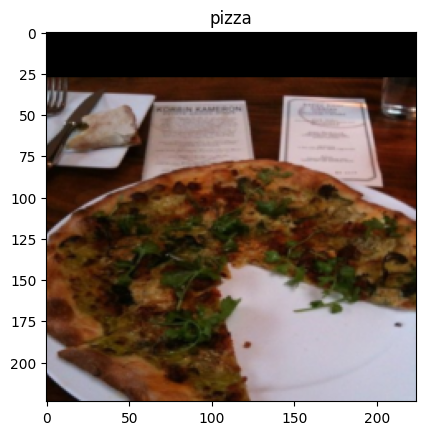

In [177]:
train_dataset = torchvision.datasets.ImageFolder(
    root=image_path / 'train',
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.TrivialAugmentWide(31),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
    ]),
)

test_dataset = torchvision.datasets.ImageFolder(
    root=image_path / 'test',
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.TrivialAugmentWide(31),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
    ])
)

BATCH_SIZE = 32
print(len(train_dataset), len(test_dataset))

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=1,     
    shuffle=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=1,
    shuffle=False,
)

classes = ["pizza", "steak", "sushi"]
# Sample data
sample = next(iter(train_loader))
print(sample[0].shape, sample[1].shape)
print(sample[0])

plt.imshow(sample[0][0].permute(1, 2, 0)) 
plt.title(classes[sample[1][0]])

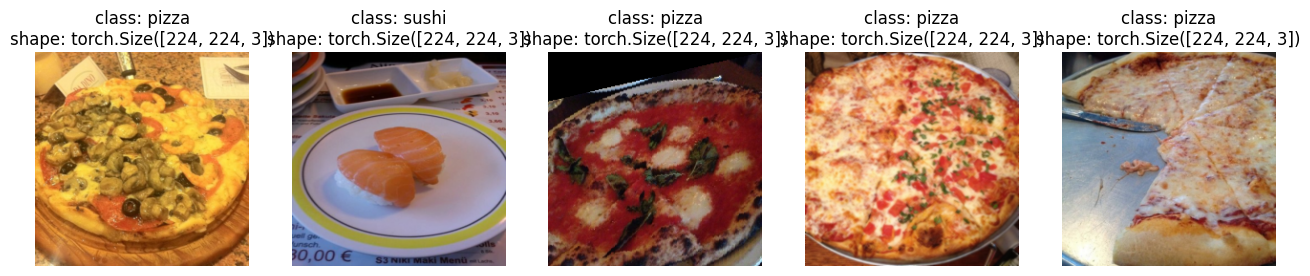

In [178]:
# Display random images
import random
from typing import List
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

# Display random images from ImageFolder created Dataset
display_random_images(train_dataset,  n=5, classes=classes, seed=None)     
    

In [181]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchsummary as summary
import os

class SELayer(nn.Module): # Also called SE-Module
    """Squeeze and Excitation Layer as described in https://arxiv.org/pdf/1709.01507.pdf"""
    def __init__(self, channels, reduction):
        super(SELayer, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor :
        module_input = x
        x = self.global_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

class SEBottleNeckBlock(nn.Module):
    """ """
    expansion = 4
    
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(SEBottleNeckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=inplanes, out_channels=planes,
                               kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=planes)
        self.conv2 = nn.Conv2d(in_channels=planes, out_channels=planes,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SELayer(channels=planes * 4, reduction=4)
        
        self.downsample = downsample
        self.stride = stride
        
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out1 = self.se_module(out)
        out2 = out1 + residual
        out2 = self.relu(out)

        return out2

class SEResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(SEResNet, self).__init__()
        """SeNet Neural Network Architecture
        
        Args:
            block (): 
            layers (): 
            num_classes (int): number of resulting classes, i.e. ImageNet has 1000 classes
        """
        
        self.inplanes = 64
        
        # Regular Block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1)
        # SELayers
        self.layer1 = self._make_layer(block, 64, layers[0])
        # self.layer2 = self._make_layer(block, 128, layers[1], stride=2) 
        # self.layer2 = self._make_layer(block, 256, layers[2], stride=2) 
        # self.layer2 = self._make_layer(block, 512, layers[3], stride=2) 
        
        # Output
        self.avgpool = nn.AvgPool2d(kernel_size=7)
        self.fc = nn.Linear(in_features=64 * 256, out_features=num_classes) # Recalculate this
        
    def _make_layer(self, block, planes, block_count, stride=1):
        """ 
        block : block type
        planes : number of output channels
        blocks : number of blocks per layer
        stride : stride
        """
        
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
            
        se_blocks = []
        se_blocks.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, block_count):
            se_blocks.append(block(self.inplanes, planes))
            
        return nn.Sequential(*se_blocks)

        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
         # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, 
                               kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16,
                               kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # Linear Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=50176, out_features=10, bias=True)
        self.fc2 = nn.Linear(in_features=10, out_features=3, bias=True)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the network.
        """
        # Block 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # Block 2
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
            
        # Dense 
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [193]:
# model = SEResNet(SEBottleNeckBlock, [3], num_classes=3).to(device)

model = SimpleCNN().to(device)

EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [194]:
def train(model: nn.Module, 
            train_loader: DataLoader,
            test_loader: DataLoader,
            loss_fn: nn.Module,
            optimizer: torch.optim.Optimizer,
            device: torch.device = torch.device("cpu")) -> dict:
    
    history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_loader, loss_fn, device)
        
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)
        
        if epoch % 1 == 0:
            print(f"Epoch: {epoch}, Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f}, Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.5f}")
        
    return history

def train_step(model: nn.Module, 
                train_loader: DataLoader,
                loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer,
                device: torch.device = torch.device("cpu")) -> tuple:

    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)               # Forward pass
        loss = loss_fn(y_pred, y)       # Calculate loss
        optimizer.zero_grad()           # Zero out gradients
        loss.backward()                 # Backpropagation
        optimizer.step()                # Update weights
        
        # print(X.shape, y.shape, y_pred.shape)
        y_pred = torch.softmax(y_pred, dim=1)
        train_acc += (y_pred.argmax(1) == y).type(torch.float).sum().item() / len(y) * 100
        train_loss += loss.item()
        
        # Clear memory
        torch.mps.empty_cache()
        
    return train_loss / len(train_loader), train_acc / len(train_loader)

def test_step(model: nn.Module, 
                test_loader: DataLoader,
                loss_fn: nn.Module, 
                device: torch.device = torch.device("cpu")) -> tuple:
    
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        model.eval()
        for batch, (X, y) in enumerate(test_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)               # Forward pass
            loss = loss_fn(y_pred, y)       # Calculate loss 
            y_pred = torch.softmax(y_pred, dim=1)
            test_acc += (y_pred.argmax(1) == y).type(torch.float).sum().item() / len(y) * 100
            test_loss += loss.item()
            
    return test_loss / len(test_loader), test_acc / len(test_loader)

history = train(model, train_loader, test_loader, loss_fn, optimizer, device)


Epoch: 0, Train Loss: 9.77047, Train Acc: 37.10938, Test Loss: 4.03011, Test Acc: 26.04167
Epoch: 1, Train Loss: 2.48203, Train Acc: 42.18750, Test Loss: 1.78133, Test Acc: 19.79167
Epoch: 2, Train Loss: 1.20199, Train Acc: 35.54688, Test Loss: 1.02290, Test Acc: 54.26136
Epoch: 3, Train Loss: 1.10299, Train Acc: 35.54688, Test Loss: 1.09315, Test Acc: 36.17424
Epoch: 4, Train Loss: 1.14236, Train Acc: 22.26562, Test Loss: 1.09114, Test Acc: 37.12121
Epoch: 5, Train Loss: 1.10569, Train Acc: 30.07812, Test Loss: 1.04787, Test Acc: 54.16667
Epoch: 6, Train Loss: 1.10591, Train Acc: 43.35938, Test Loss: 1.02922, Test Acc: 59.37500
Epoch: 7, Train Loss: 1.14904, Train Acc: 34.37500, Test Loss: 1.08993, Test Acc: 33.90152
Epoch: 8, Train Loss: 1.11244, Train Acc: 31.64062, Test Loss: 1.10632, Test Acc: 19.79167
Epoch: 9, Train Loss: 1.09102, Train Acc: 41.40625, Test Loss: 1.11607, Test Acc: 19.79167


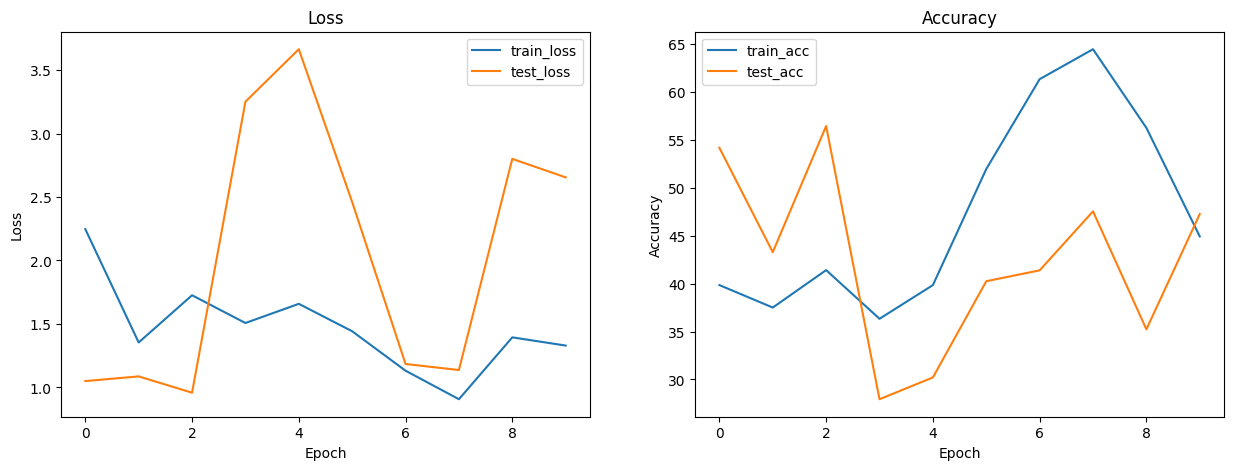

In [186]:
# Plot the history
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(history["train_loss"], label="train_loss")
axes[0].plot(history["test_loss"], label="test_loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss")
axes[0].legend()

axes[1].plot(history["train_acc"], label="train_acc")
axes[1].plot(history["test_acc"], label="test_acc")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy")
axes[1].legend()


In [187]:
# Evaluate
def eval_model(model: nn.Module, 
               test_loader: DataLoader, 
               loss_fn: nn.Module) -> dict:
    loss, acc = 0.0, 0.0
    confusion_matrix = torch.zeros(3, 3)
    
    model.eval()
    with torch.inference_mode():
        for (X, y) in test_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            loss += loss_fn(test_pred, y)
            acc += (test_pred.argmax(dim=1) == y).sum().item() / len(y) * 100
            
            # Confusion matrix
            for t, p in zip(y.view(-1), test_pred.argmax(dim=1).view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    
        loss /= len(test_loader)
        acc /= len(test_loader)
        
    return {
        "model_name": model.__class__.__name__,
        "loss": loss.item(),
        "acc": acc
    }, confusion_matrix
    
results, confusion_matrix = eval_model(model, test_loader, loss_fn)
print(results)

{'model_name': 'SEResNet', 'loss': 2.445819139480591, 'acc': 48.1060606060606}


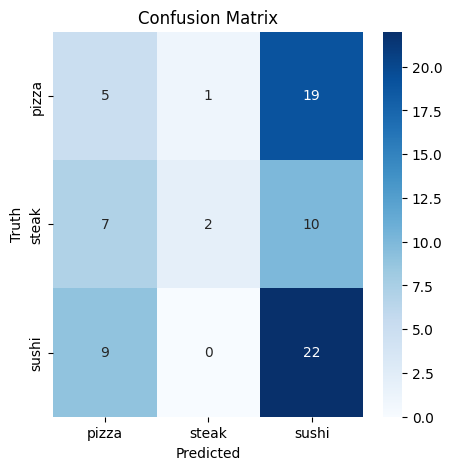

In [188]:
# Plot confusion matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, ax=ax, fmt='g', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Truth")
# Labels with class names
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)
plt.title("Confusion Matrix")
plt.show()

In [189]:
# Make predictions
def make_predictions(mode: nn.Module, 
                     data: list,
                     device: torch.device = 'cpu') -> list:
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for X in data:
            X = X.to(device)
            X = X.unsqueeze(0)
            pred_prob = model(X)
            pred_probs.append(pred_prob)
            
    return pred_probs
        
# Get random samples    
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label)
    
# View the first sample shape
print(test_samples[0].shape)
print(test_labels[0])


torch.Size([3, 224, 224])
1


[0, 1, 0, 0, 1, 0, 1, 0, 0]


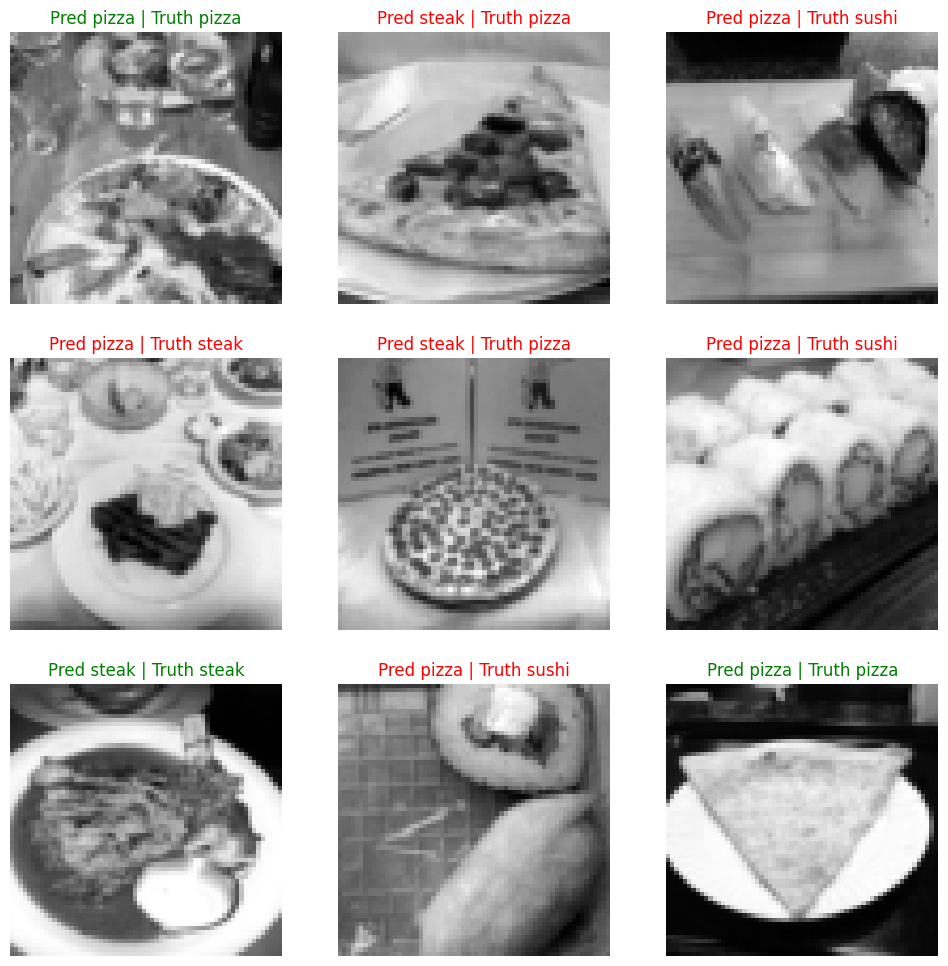

In [176]:
pred_prob = make_predictions(model, test_samples, device)
pred_classes = [ p.argmax(dim=1).item() for p in pred_prob ]
print(pred_classes)

# Plot 
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
for i in range(9):
    ax = axes[i//3, i%3]
    ax.imshow(test_samples[i][0], cmap='gray')
    title_text = f"Pred {classes[pred_classes[i]]} | Truth {classes[test_labels[i]]}"
    ax.set_title(title_text)
    
    # Change color based on prediction
    if pred_classes[i] == test_labels[i]:
        ax.set_title(title_text, color='green')
    else:
        ax.set_title(title_text, color='red')
    ax.axis('off')